# Quantum Multiplier

In this notebook, a quantum multiplier has been implemented as proposed in this paper()[https://arxiv.org/pdf/1411.5949.pdf]. 

Following is the outline of the notebook:
-  QFT
- Draper Adder
- Quantum Multiplier
- `multiplier` module
- Test run
- Future work

In [1]:
## Import libraries
from qiskit import QuantumCircuit, Aer, QuantumRegister, ClassicalRegister, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from numpy import pi

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
backend = Aer.get_backend('qasm_simulator')

## Quantum Fourier Transform (QFT)

In [22]:
def qft(n):
    circuit = QuantumCircuit(n, name = 'IQFT')
    if n == 0: # Exit function if circuit is empty
        return circuit
    
    for i in range(n-1, -1, -1):
        for j in range(i+1, n):
            circuit.cp(2*pi/2**(j-i+1), j, i) # CROT gate
        circuit.h(i)
        # circuit.barrier()
    return circuit

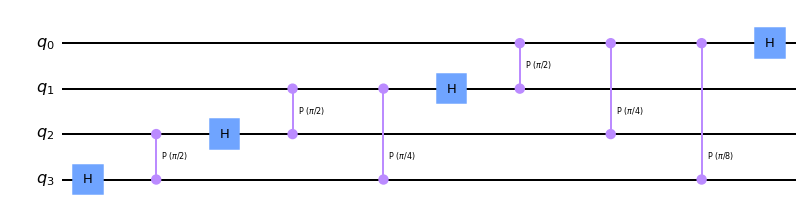

In [23]:
qfta = qft(4)
qfta.draw('mpl')

> **Note:** The barriers can be added for visual purposes to understand the flow of operations. They have been removed for better circiut optimization. To add barriers, uncomment the code in the `qft()` function.

## Draper Adder

In [24]:
## Module

def draper_adder(n):
    qcda = QuantumCircuit(2*n+1, name = 'draper_adder')
    cout = 2*n

    # QFT
    qcda.append(qft(n+1), range(n, 2*n+1))
    # qcda.barrier()

    # b -> a
    for i in range(n): # a loop
        for j in range(i+1):
            # n-1, n-i-2, -1
            qcda.cp(2*pi/2**(n-j+i-1), j, i+n)
        qcda.barrier()
    #cout
    for i in range(n):
        qcda.cp(2*pi/(2**(n-i+1)), i, cout)
    # qcda.barrier()

    # IQFT
    qcda.append(qft(n+1).inverse(), range(n, 2*n+1))
    # qcda.barrier()
    
    return qcda

### Demo circuit

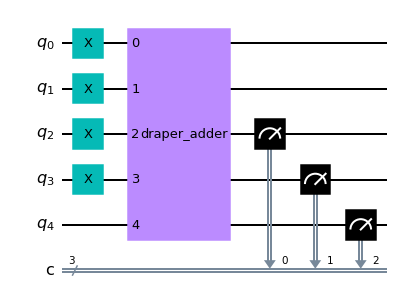

{'110': 4096}


In [25]:
draper_demo = QuantumCircuit(5, 3)
[draper_demo.x(i) for i in [0, 1, 2, 3]]

# draper_demo.append(DraperQFTAdder(2, kind = 'half'), range(5))
draper_demo.append(draper_adder(2), range(5))

draper_demo.measure(range(2, 5), range(3))

display(draper_demo.draw('mpl'))

counts = execute(draper_demo, backend, shots = 4096).result().get_counts()
print(counts)

## QFT Multiplier

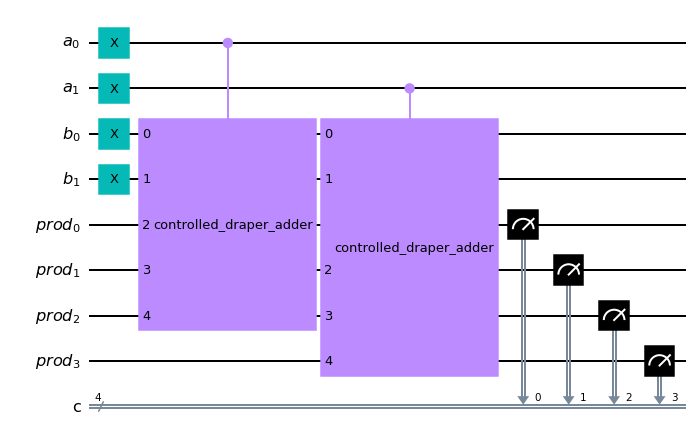

In [26]:
## QFT Multiplier

n = 2
controlled_draper = UnitaryGate(Operator(draper_adder(n)), label = 'controlled_draper_adder').control()
# Quantum Circuit
q_multiplier = QuantumCircuit(0, 2*n, name = 'quantum_multiplier')
# Data registers
a = QuantumRegister(n, 'a')
b = QuantumRegister(n, 'b')
p = QuantumRegister(2*n, 'prod')
q_multiplier.add_register(a)
q_multiplier.add_register(b)
q_multiplier.add_register(p)

# Data encoding
[q_multiplier.x(a[i]) for i in [0, 1]]
[q_multiplier.x(b[i]) for i in [0, 1]]
# q_multiplier.barrier()

for i in range(n):
    q_multiplier.append(controlled_draper, [a[i]]+b[:]+p[i:i+n+1])
# q_multiplier.barrier()

q_multiplier.measure(p[:], range(2*n))
display(q_multiplier.draw())

## Multiplier Module

In [27]:
def multiplier(number_1, number_2):
    # Convert inputs to binary
    b1 = bin(number_1)[2:]
    b2 = bin(number_2)[2:]
    n = max([len(b1), len(b2)])
    
    # The controlled draper adder
    controlled_draper = UnitaryGate(Operator(draper_adder(n)), label = 'controlled_draper_adder').control()
    
    # The quantum circuit
    q_multiplier = QuantumCircuit(0, 2*n, name = 'quantum_multiplier')
    # Data registers
    a = QuantumRegister(n, 'a')
    b = QuantumRegister(n, 'b')
    p = QuantumRegister(2*n, 'prod')
    q_multiplier.add_register(a)
    q_multiplier.add_register(b)
    q_multiplier.add_register(p)

    # Data encoding
    for i in range(len(b1)):
        if b1[i] == '1':
            q_multiplier.x(a[len(b1)-i-1])
    for i in range(len(b2)):
        if b2[i] == '1':
            q_multiplier.x(b[len(b2)-i-1])
    
    # The QFT multiplier stage
    for i in range(n):
        # q_multiplier.append(draper_adder(n), a[:]+p[i:i+n+1])
        q_multiplier.append(controlled_draper, [a[i]]+b[:]+p[i:i+n+1])

    q_multiplier.measure(p[:], range(2*n))
    
    # Simulation
    backend = Aer.get_backend('qasm_simulator')
    counts = execute(q_multiplier, backend, shots = 10).result().get_counts()
    return int(list(counts.keys())[0], 2) # Retrieving the key element and returning the int value

### Sample Runs

In [28]:
prod = multiplier(2, 2)
print(prod)

4


In [29]:
prod = multiplier(1, 3)
print(prod)

3


> **Note:** The running time increases with increase in the size of qubit register. Hence, the tests have been restricted to 2-qubit registers.

## Future work

- The circuits can be transpiled by using the `transpile()` method of Qiskit for circuit optimization. 
- The runtime of the circuits can be assessed corresponding to their circuit depths. 